In [2]:
import os
import numpy as np
import matplotlib.pyplot as pl

In [9]:
base_dir = '/nas/vhluong/Result/Orion_ablation_study/debug_GordonHCP'
version = 'version_6'
train_folder = os.path.join(base_dir, version, 'train_performance_ukb')
test_folder = os.path.join(base_dir, version, 'test_performance_ukb')
print(train_folder)
print(test_folder)

/nas/vhluong/Result/Orion_ablation_study/debug_GordonHCP/version_6/train_performance_ukb
/nas/vhluong/Result/Orion_ablation_study/debug_GordonHCP/version_6/test_performance_ukb


In [11]:
batch_num = 1
orig = np.load(test_folder + '/orig_batch_'+str(batch_num)+'.npy')[:, :200, :]
pred = np.load(test_folder+'/pred_batch_'+str(batch_num)+'.npy')[:, :200, :]
# mask = np.load(test_folder+'/mask_batch_'+str(batch_num)+'.npy')
print("Original:", orig.shape)
print("Prediction:", pred.shape)
# print("Mask:", mask.shape)

Original: (16, 200, 450)
Prediction: (16, 200, 450)


In [13]:
# orig = np.load(test_folder + '/orig_batch_'+str(batch_num)+'.npy')[:, :200, :]
# pred = np.load(test_folder+'/pred_batch_'+str(batch_num)+'.npy')[:, :200, :]

# orig = np.load(test_folder + '/orig_batch_' + str(batch_num) + '.npy')
# pred = np.load(test_folder + '/pred_batch_' + str(batch_num) + '.npy')

# Mean Squared Error
mse = np.mean((orig - pred) ** 2)
print("MSE:", mse)

# ---- R^2 score implementation ----
# Flatten everything so we treat it as one big regression problem
y_true = orig.reshape(-1)
y_pred = pred.reshape(-1)

# Sum of squares of residuals
ss_res = np.sum((y_true - y_pred) ** 2)

# Total sum of squares (relative to mean of true values)
y_mean = np.mean(y_true)
ss_tot = np.sum((y_true - y_mean) ** 2)

if ss_tot == 0:
    # All y_true are identical → R^2 is undefined; conventionally return 0.0
    r2 = 0.0
else:
    r2 = 1.0 - ss_res / ss_tot

print(ss_res)
print(ss_tot)
print("R^2:", r2)

mse = np.mean((orig - pred) ** 2)
print(mse)

MSE: 31530590000000.0
4.540405e+19
42073160000.0
R^2: -1079169000.0
31530590000000.0


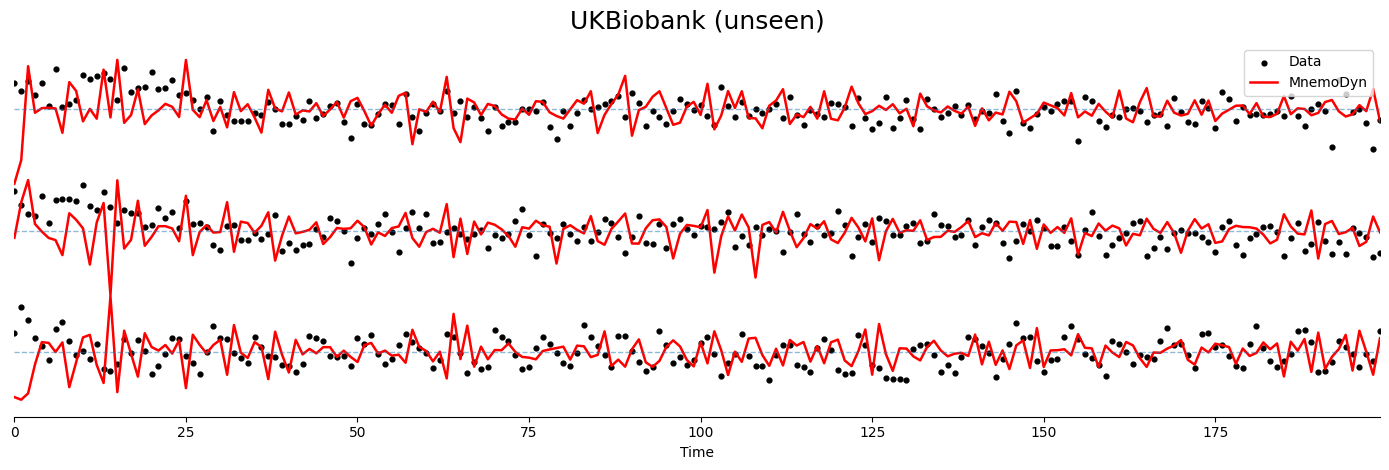

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import string

# ==== Config ====
b = 3                     # batch index
feats = [0, 1, 2]         # three parcel indices to show
title = "UKBiobank (unseen)"
point_size = 12
line_width = 1.8
normalize = True          # z-score each parcel to make wiggles visible

# ==== Helpers ====
def zscore(x, axis=0, eps=1e-8):
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    return (x - mu) / (sd + eps)

# ==== Extract & (optionally) normalize ====
T = orig.shape[1]
t = np.arange(T)

# assemble arrays [num_feats, T]
data_stack = np.stack([orig[b, :, f] for f in feats], axis=0)
model_stack = np.stack([pred[b, :, f] for f in feats], axis=0)

if normalize:
    data_stack  = zscore(data_stack, axis=1)
    model_stack = zscore(model_stack, axis=1)

# vertical spacing
# after z-scoring, each track is ~[-3, 3]; pick gap to separate visually
track_half_height = 3.0
gap = 2.5                              # distance between track centers
offsets = (np.arange(len(feats))[::-1]) * (2*track_half_height + gap)

# ==== Plot ====
plt.figure(figsize=(14, 4.8))
ax = plt.gca()

added = {"Data": False, "MnemoDyn": False}

for i, f in enumerate(feats):
    off = offsets[i]
    y_data  = data_stack[i]  + off
    y_model = model_stack[i] + off

    # data (black dots)
    ax.scatter(
        t, y_data, s=point_size, color="black",
        label=("Data" if not added["Data"] else None)
    ); added["Data"] = True

    # model (red line)
    # ax.scatter(
    #     t, y_model, s = point_size, color="blue",
    #     label=("MNemoDyn" if not added["MNemoDyn"] else None)
    # ); added["MNemoDyn"] = True

    ax.plot(
        t, y_model, color="red", linewidth=line_width,
        label=("MnemoDyn" if not added["MnemoDyn"] else None)
    ); added["MnemoDyn"] = True

    # dashed zero line for each parcel
    ax.hlines(off, t[0], t[-1], linestyles="dashed", linewidth=1, alpha=0.5)

    # # left-side label: Parcel A/B/C...
    # ax.text(t[0] - (0.03 * T), off, f"Parcel {string.ascii_uppercase[i]}",
    #         va="center", ha="right", fontsize=11)

# cosmetics
ax.set_xlim(t[0], t[-1])
ax.set_yticks([])
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.set_xlabel("Time")
ax.set_title(title, fontsize=18, pad=10)
ax.legend(loc="upper right", frameon=True)



plt.tight_layout()
# Vector format (best for zooming, publications)
plt.savefig("mnemodyn_plot_hcp_aging.pdf", bbox_inches="tight")

# # OR high-resolution PNG (e.g., 600 DPI)
# plt.savefig("orion_ae_plot.png", dpi=600, bbox_inches="tight")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# pick one sample and one feature
b = 1   # batch index
d = 0  # feature index

t = np.arange(orig.shape[1])   # time axis [0..489]

orig_series = orig[b, :, d]
pred_series = pred[b, :, d]
mask_series = mask[b, :, d].astype(bool)

plt.figure(figsize=(14, 5))

# plot original vs prediction
plt.plot(t, orig_series, label="Original", alpha=0.7)
plt.plot(t, pred_series, label="Prediction", alpha=0.7)

# highlight masked regions
plt.fill_between(
    t,
    np.min([orig_series.min(), pred_series.min()]) - 0.1,
    np.max([orig_series.max(), pred_series.max()]) + 0.1,
    where=mask_series,
    color="red",
    alpha=0.2,
    label="Masked"
)

plt.title(f"Sample {b}, Feature {d}")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

b = 1  # batch index
T, D = orig.shape[1], orig.shape[2]
t = np.arange(T)

for d in range(D):
    plt.figure(figsize=(14, 4))
    plt.plot(t, orig[b, :, d], color="black", linewidth=1.2)
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.5)
    plt.title(f"Sample {b}, Parcel {d}")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import string

# # ==== Config ====
# b = 0                     # batch index
# feats = [100, 101, 102]         # parcels to show
# title = "UK Biobank (unseen data) — Masked Regions Only"
# point_size = 12
# line_width = 1.8
# normalize = True          # z-score each parcel
# tighten_x_to_mask = True  # zoom x to union of masked timepoints

# # ==== Helpers ====
# def zscore(x, axis=0, eps=1e-8):
#     mu = np.nanmean(x, axis=axis, keepdims=True)
#     sd = np.nanstd(x, axis=axis, keepdims=True)
#     return (x - mu) / (sd + eps)

# # ==== Extract ====
# T = orig.shape[1]
# t = np.arange(T)

# data_stack  = np.stack([orig[b, :, f] for f in feats], axis=0)
# model_stack = np.stack([pred[b, :, f] for f in feats], axis=0)
# mask_stack  = np.stack([mask[b, :, f].astype(bool) for f in feats], axis=0)

# if normalize:
#     data_stack  = zscore(data_stack, axis=1)
#     model_stack = zscore(model_stack, axis=1)

# # vertical spacing (after z-scoring, tracks ~[-3,3])
# track_half_height = 3.0
# gap = 2.5
# offsets = (np.arange(len(feats))[::-1]) * (2*track_half_height + gap)

# # ==== Plot (masked-only) ====
# plt.figure(figsize=(14, 4.8))
# ax = plt.gca()

# added = {"Data": False, "Orion-MAE": False}
# all_mask_idxs = []

# for i, f in enumerate(feats):
#     off = offsets[i]
#     y_data  = data_stack[i].copy()
#     y_model = model_stack[i].copy()
#     m = mask_stack[i]

#     if not m.any():
#         # no masked points for this parcel; draw only baseline + label
#         ax.hlines(off, 0, T-1, linestyles="dashed", linewidth=1, alpha=0.5)
#         ax.text(t[0] - (0.03 * T), off, f"Parcel {string.ascii_uppercase[i]}",
#                 va="center", ha="right", fontsize=11)
#         continue

#     all_mask_idxs.append(np.flatnonzero(m))

#     # Hide unmasked points by setting them to NaN
#     y_data[~m]  = np.nan
#     y_model[~m] = np.nan

#     # Offset for stacking
#     y_data  = y_data  + off
#     y_model = y_model + off

#     # data (black dots) at masked times
#     ax.scatter(
#         t[m], y_data[m], s=point_size, color="black",
#         label=("Data" if not added["Data"] else None)
#     ); added["Data"] = True

#     # model (red line) shown only on masked segments (gaps elsewhere)
#     ax.plot(
#         t, y_model, color="red", linewidth=line_width,
#         label=("Orion-MAE" if not added["Orion-MAE"] else None)
#     ); added["Orion-MAE"] = True

#     # dashed zero line + parcel label
#     ax.hlines(off, 0, T-1, linestyles="dashed", linewidth=1, alpha=0.5)
#     ax.text(t[0] - (0.03 * T), off, f"Parcel {string.ascii_uppercase[i]}",
#             va="center", ha="right", fontsize=11)

# # cosmetics
# if tighten_x_to_mask and len(all_mask_idxs) > 0:
#     u = np.unique(np.concatenate(all_mask_idxs))
#     ax.set_xlim(max(0, u.min()-5), min(T-1, u.max()+5))
# else:
#     ax.set_xlim(0, T-1)

# ax.set_yticks([])
# for spine in ["top", "right", "left"]:
#     ax.spines[spine].set_visible(False)

# ax.set_xlabel("Time")
# ax.set_title(title, fontsize=18, pad=10)
# ax.legend(loc="upper right", frameon=True)

# plt.tight_layout()
# plt.savefig("orion_ae_masked_only.pdf", bbox_inches="tight")   # vector = no blur
# # plt.savefig("orion_ae_masked_only.png", dpi=600, bbox_inches="tight")  # optional raster
# plt.show()


Found files: ['./visualization/activations_level0.npz', './visualization/activations_level1.npz', './visualization/activations_level2.npz', './visualization/activations_level3.npz', './visualization/activations_level4.npz']
Loaded 5 levels
(600, 245)


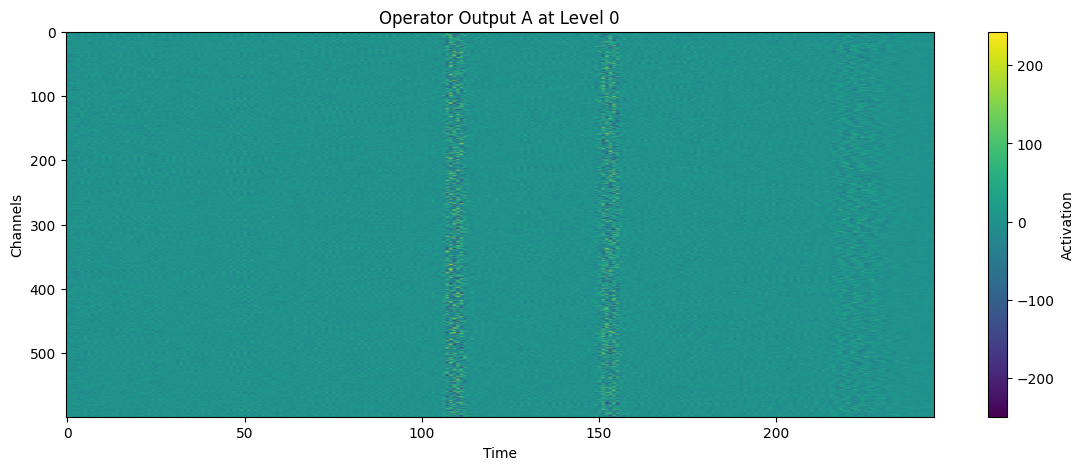

In [73]:
# ================================
# LOAD ACTIVATIONS FROM NPZ FILES
# ================================
import numpy as np
import matplotlib.pyplot as plt
import glob

# Path to your saved activations
files = sorted(glob.glob("./visualization/activations_level*.npz"))

print("Found files:", files)

# Dictionary mapping level → data dict
acts = {}
for f in files:
    level = int(f.split("level")[1].split(".")[0])
    acts[4 - level] = np.load(f)
    
print(f"Loaded {len(acts)} levels")


# =====================================================
# PANEL A — VISUALIZE WAVELET BANDS u_j (detail + approx)
# =====================================================
def plot_wavelet_bands(level, acts):
    data = acts[level]
    detail = data["detail"][0]   # (C, T)
    approx = data["approx"][0]   # (C, T)

    plt.figure(figsize=(12, 4))
    plt.plot(detail[0], label="detail (high freq)")
    plt.plot(approx[0], label="approx (low freq)")
    plt.title(f"Wavelet Bands at Level {level}")
    plt.xlabel("Time")
    plt.ylabel("Activation")
    plt.legend()
    plt.show()


# Example: visualize level 3 (you can change this)
# plot_wavelet_bands(level=3, acts=acts)



# ============================================================
# PANEL B — VISUALIZE OPERATOR OUTPUT A_j(u_j) AS HEATMAP
# ============================================================
def plot_operator_output(level, acts):
    data = acts[level]
    op = data["operator_output"][0]  # (2C, T)
    print(op.shape)
    plt.figure(figsize=(14, 5))
    plt.imshow(op, aspect="auto", cmap="viridis")
    plt.colorbar(label="Activation")
    plt.title(f"Operator Output A at Level {level}")
    plt.xlabel("Time")
    plt.ylabel("Channels")
    plt.show()


# Example: visualize operator output at level 3
plot_operator_output(level=0, acts=acts)

def plot_operator_output_after_act(level, acts):
    data = acts[level]
    op_post = data["operator_output_after_act"][0]  # (2C, T)

    plt.figure(figsize=(14, 5))
    plt.imshow(op_post, aspect="auto", cmap="viridis")
    plt.colorbar(label="Post-Activation Value")
    plt.title(f"Post-Activation Output at Level {level}")
    plt.xlabel("Time")
    plt.ylabel("Channels")
    plt.show()

# plot_operator_output_after_act(level=4, acts=acts)

#9
#2
#1
#0


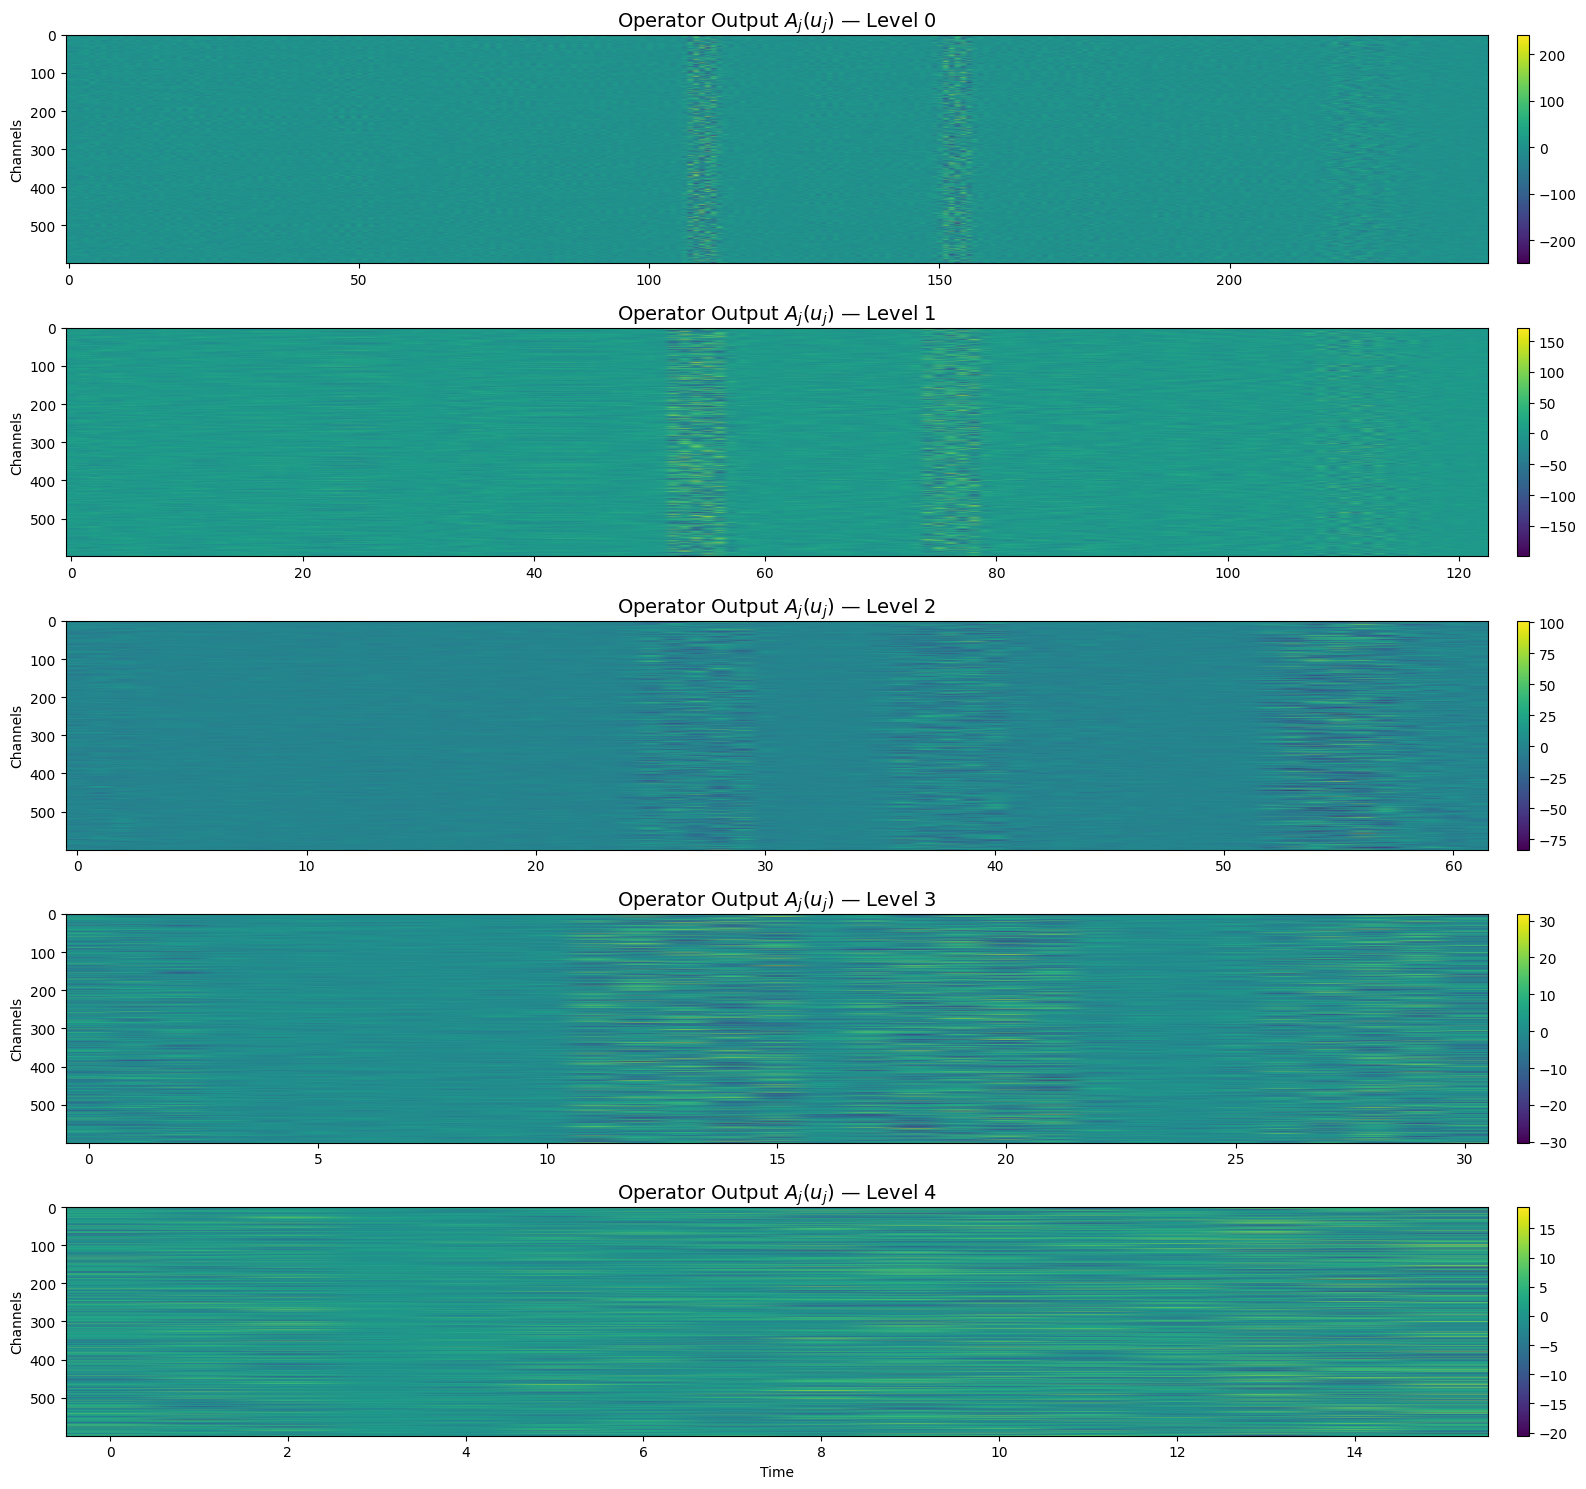

[Saved PDF] operator_outputs_levels_0_to_4.pdf


In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Acts is your dictionary: acts[level] = loaded data dict

def plot_all_operator_outputs(acts, levels=(0,1,2,3,4), save_path="operator_outputs_levels_0_to_4.pdf"):
    num_levels = len(levels)
    fig, axes = plt.subplots(num_levels, 1, figsize=(16, 3*num_levels), sharex=False)

    if num_levels == 1:
        axes = [axes]  # ensure list for consistent indexing

    for i, level in enumerate(levels):
        data = acts[level]
        op = data["operator_output"][0]  # (2C, T)

        ax = axes[i]
        img = ax.imshow(op, aspect="auto", cmap="viridis")
        ax.set_title(f"Operator Output $A_j(u_j)$ — Level {(level)}", fontsize=14)
        ax.set_ylabel("Channels")
        fig.colorbar(img, ax=ax, fraction=0.02, pad=0.02)

    axes[-1].set_xlabel("Time")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"[Saved PDF] {save_path}")


# ===========================
# CALL THE FUNCTION
# ===========================
plot_all_operator_outputs(acts, levels=[0, 1, 2, 3, 4])


In [18]:
print(acts[0].keys())

KeysView(NpzFile './visualization_hcp/activations_level0.npz' with keys: approx, detail, raw_input, operator_output, operator_output_after_act)


7801.7534
5326.92
2162.1704
870.3815
425.90393
245


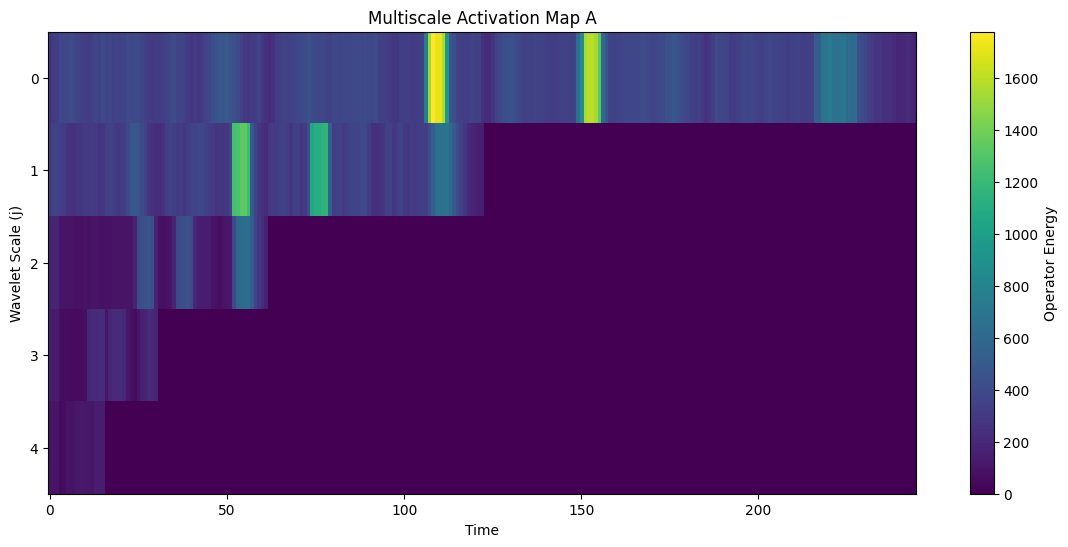

In [ ]:
# ============================================================
# PANEL C — MULTISCALE ACTIVATION MAP (ACROSS ALL LEVELS)
# ============================================================
def plot_multiscale_activation_map(acts):
    activation_levels = []

    # Compute energy per time for each scale j
    for level in sorted(acts.keys()):
        # if level == 0: 
        #     continue
        op = acts[level]["operator_output"][0]  # (2C, T_j)
        energy = np.linalg.norm(op, axis=0)     # (T_j,)
        print(np.linalg.norm(op))
        activation_levels.append(energy)

    # Pad all energy time series to same length
    max_len = max(e.shape[0] for e in activation_levels)
    print(max_len)
    padded = []

    for e in activation_levels:
        if e.shape[0] < max_len:
            pad = np.pad(e, (0, max_len - e.shape[0]))
            padded.append(pad)
        else:
            padded.append(e)

    activation_map = np.stack(padded)  # (num_levels, time)

    plt.figure(figsize=(14, 6))
    plt.imshow(activation_map, aspect="auto", cmap="viridis")
    plt.colorbar(label="Operator Energy")
    plt.title("Multiscale Activation Map A")
    plt.xlabel("Time")
    plt.ylabel("Wavelet Scale (j)")
    plt.show()


# Visualize the full multiscale activation map
plot_multiscale_activation_map(acts)

Original duration: 381.600s  (len=478, TR=0.8)
Target duration:   359.415s  (len=490, TR=0.735)
Duration delta:    -22.185s
Target extends beyond original time? False (target last t=359.415, orig last t=381.600)


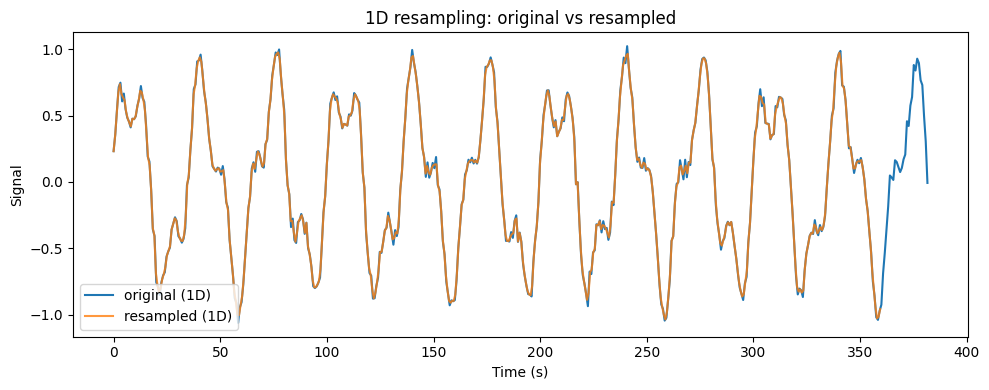

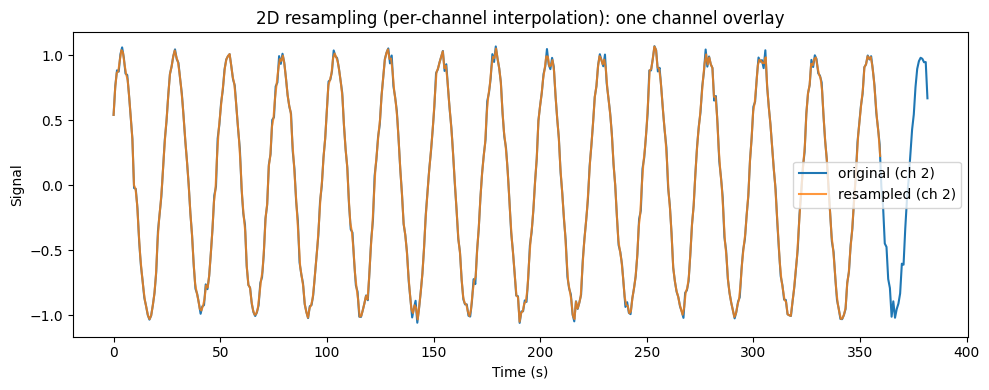

Shapes:
  x_1d: (478,) -> (490,)
  X_2d: (478, 5) -> (490, 5)


In [1]:
# Demo: resample_timeseries (1D + multi-channel) in a notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def resample_timeseries(data, orig_TR=0.8, target_TR=0.735, target_length=490, kind="linear", extrapolate=True):
    """
    Resample a timeseries to match target length and TR.

    Args:
        data (np.ndarray): shape (T, D) or (T,)
        orig_TR (float): original TR (seconds)
        target_TR (float): target TR (seconds)
        target_length (int): desired number of timepoints
        kind (str): interpolation kind (e.g. 'linear', 'cubic')
        extrapolate (bool): if True, allow extrapolation beyond original time range

    Returns:
        np.ndarray: resampled array of shape (target_length,) or (target_length, D)
    """
    data = np.asarray(data)
    orig_len = data.shape[0]

    orig_time = np.arange(orig_len) * orig_TR
    target_time = np.arange(target_length) * target_TR

    fill_value = "extrapolate" if extrapolate else (data[0] if data.ndim == 1 else data[0, :],
                                                   data[-1] if data.ndim == 1 else data[-1, :])

    # 1D case
    if data.ndim == 1:
        f = interp1d(orig_time, data, kind=kind, fill_value=fill_value, bounds_error=False)
        return f(target_time)

    # 2D case (T, D)
    resampled = np.zeros((target_length, data.shape[1]), dtype=float)
    for d in range(data.shape[1]):
        f = interp1d(orig_time, data[:, d], kind=kind, fill_value=fill_value, bounds_error=False)
        resampled[:, d] = f(target_time)
    return resampled


# -------------------------
# Create synthetic data
# -------------------------
np.random.seed(0)

orig_TR = 0.8
target_TR = 0.735
orig_len = 478
target_length = 490

orig_time = np.arange(orig_len) * orig_TR
target_time = np.arange(target_length) * target_TR

# 1D: mix of sinusoids + noise
x_1d = (
    0.7 * np.sin(2 * np.pi * 0.03 * orig_time) +
    0.3 * np.sin(2 * np.pi * 0.08 * orig_time + 0.5) +
    0.05 * np.random.randn(orig_len)
)

# 2D: 5 channels with slightly different phases/frequencies
D = 5
X_2d = np.stack([
    np.sin(2 * np.pi * (0.02 + 0.01*d) * orig_time + 0.3*d) + 0.05*np.random.randn(orig_len)
    for d in range(D)
], axis=1)  # (T, D)

# -------------------------
# Resample
# -------------------------
x_1d_rs = resample_timeseries(x_1d, orig_TR=orig_TR, target_TR=target_TR, target_length=target_length,
                             kind="linear", extrapolate=True)

X_2d_rs = resample_timeseries(X_2d, orig_TR=orig_TR, target_TR=target_TR, target_length=target_length,
                             kind="linear", extrapolate=True)

# -------------------------
# Print duration check
# -------------------------
orig_duration = (orig_len - 1) * orig_TR
target_duration = (target_length - 1) * target_TR
print(f"Original duration: {orig_duration:.3f}s  (len={orig_len}, TR={orig_TR})")
print(f"Target duration:   {target_duration:.3f}s  (len={target_length}, TR={target_TR})")
print(f"Duration delta:    {target_duration - orig_duration:+.3f}s")

# Check if target_time exceeds original time range (causes extrapolation)
exceeds = target_time[-1] > orig_time[-1]
print(f"Target extends beyond original time? {exceeds} "
      f"(target last t={target_time[-1]:.3f}, orig last t={orig_time[-1]:.3f})")

# -------------------------
# Plot 1D overlay
# -------------------------
plt.figure(figsize=(10, 4))
plt.plot(orig_time, x_1d, label="original (1D)")
plt.plot(target_time, x_1d_rs, label="resampled (1D)", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("1D resampling: original vs resampled")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Plot one channel from 2D overlay
# -------------------------
ch = 2
plt.figure(figsize=(10, 4))
plt.plot(orig_time, X_2d[:, ch], label=f"original (ch {ch})")
plt.plot(target_time, X_2d_rs[:, ch], label=f"resampled (ch {ch})", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("2D resampling (per-channel interpolation): one channel overlay")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Show shapes
# -------------------------
print("Shapes:")
print("  x_1d:", x_1d.shape, "->", x_1d_rs.shape)
print("  X_2d:", X_2d.shape, "->", X_2d_rs.shape)